  
 Question 1
 
 How do different demographic groups, like age, gender, and marital status, differ in their payment history and default rates?
  

In [2]:
import pandas as pd

In [3]:
df = pd.read_excel('default of credit card clients.xlsx', sheet_name='Data', skiprows=1)
df.columns = [
    "ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "DEFAULT"
]
df.drop(columns=["ID"], inplace=True)  # Drop irrelevant columns

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Here we will Select features for clustering
clustering_data = df[["SEX", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]]

# Scaling the data
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

In [5]:
# Here we will perform k-mean clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(clustering_data_scaled)

# Adding cluster labels to the dataset
df["Cluster"] = clusters

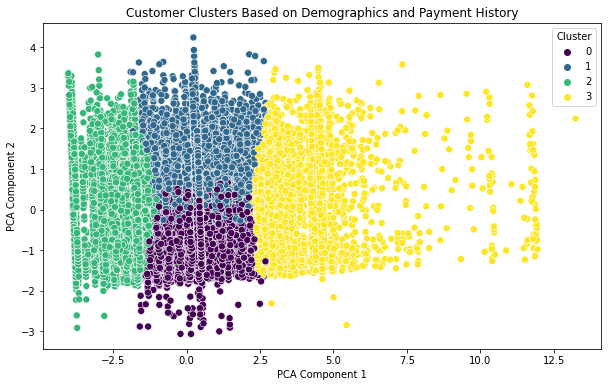

In [6]:
#  PCA 
pca = PCA(n_components=2)
pca_data = pca.fit_transform(clustering_data_scaled)
df["PCA1"] = pca_data[:, 0]
df["PCA2"] = pca_data[:, 1]

# plotting clusters using scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Cluster"], palette="viridis", s=50)
plt.title("Customer Clusters Based on Demographics and Payment History")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

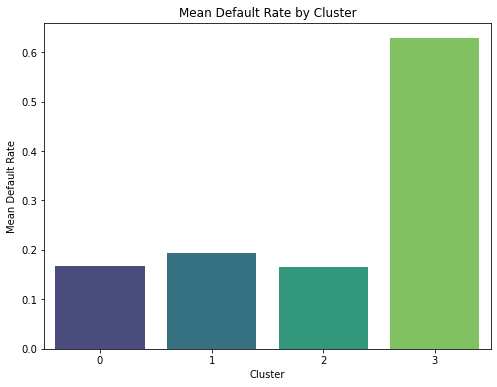

In [7]:
# Here we will calculate default rates and customer count for every cluster.
cluster_summary = df.groupby("Cluster").agg(
    mean_default_rate=("DEFAULT", "mean"),
    customer_count=("DEFAULT", "size")
).reset_index()

# plotting default rates by cluster using bargraph
plt.figure(figsize=(8, 6))
sns.barplot(x="Cluster", y="mean_default_rate", data=cluster_summary, palette="viridis")
plt.title("Mean Default Rate by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Mean Default Rate")
plt.show()

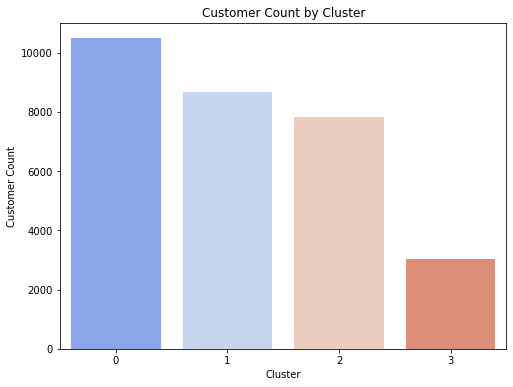

In [8]:
# plotting customer count by cluster using bargraph
plt.figure(figsize=(8, 6))
sns.barplot(x="Cluster", y="customer_count", data=cluster_summary, palette="coolwarm")
plt.title("Customer Count by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Customer Count")
plt.show()

In [9]:
# Recreate demographic_cluster_analysis
demographic_cluster_analysis = df.groupby("Cluster").agg(
    mean_age=("AGE", "mean"),
    median_age=("AGE", "median"),
    gender_distribution=("SEX", lambda x: x.value_counts(normalize=True).to_dict()),
    marital_status_distribution=("MARRIAGE", lambda x: x.value_counts(normalize=True).to_dict()),
    customer_count=("Cluster", "size")
).reset_index()

# Function to format demographic traits analysis into a tabular format
def format_demographic_cluster_analysis(demographic_cluster_analysis):
    table_data = []

    for _, row in demographic_cluster_analysis.iterrows():
        # Gender distribution
        gender_dist = row["gender_distribution"]
        male_percentage = round(gender_dist.get(1, 0) * 100, 2)
        female_percentage = round(gender_dist.get(2, 0) * 100, 2)

        # Marital status distribution
        marital_dist = row["marital_status_distribution"]
        married_percentage = round(marital_dist.get(1, 0) * 100, 2)
        single_percentage = round(marital_dist.get(2, 0) * 100, 2)
        others_percentage = round(marital_dist.get(3, 0) * 100, 2)

        # arranging data to show in tabel format.
        table_data.append({
            "Cluster": row["Cluster"],
            "Mean Age": round(row["mean_age"], 2),
            "Median Age": row["median_age"],
            "Male (%)": male_percentage,
            "Female (%)": female_percentage,
            "Married (%)": married_percentage,
            "Single (%)": single_percentage,
            "Others (%)": others_percentage,
            "Customer Count": row["customer_count"]
        })

    # creating a dataframe for the table
    formatted_table = pd.DataFrame(table_data)

    # display
    print("\n--- Demographic Traits by Cluster (Tabular Format) ---\n")
    print(formatted_table.to_string(index=False))

# Calling the function to format and display the demographic analysis
format_demographic_cluster_analysis(demographic_cluster_analysis)


--- Demographic Traits by Cluster (Tabular Format) ---

 Cluster  Mean Age  Median Age  Male (%)  Female (%)  Married (%)  Single (%)  Others (%)  Customer Count
       0     30.55          29     42.41       57.59         0.00       97.47        2.53           10484
       1     40.53          40     38.91       61.09        95.27        4.31        0.00            8654
       2     36.81          36     34.25       65.75        51.50       47.91        0.42            7815
       3     34.74          33     45.88       54.12        45.59       53.43        0.82            3047


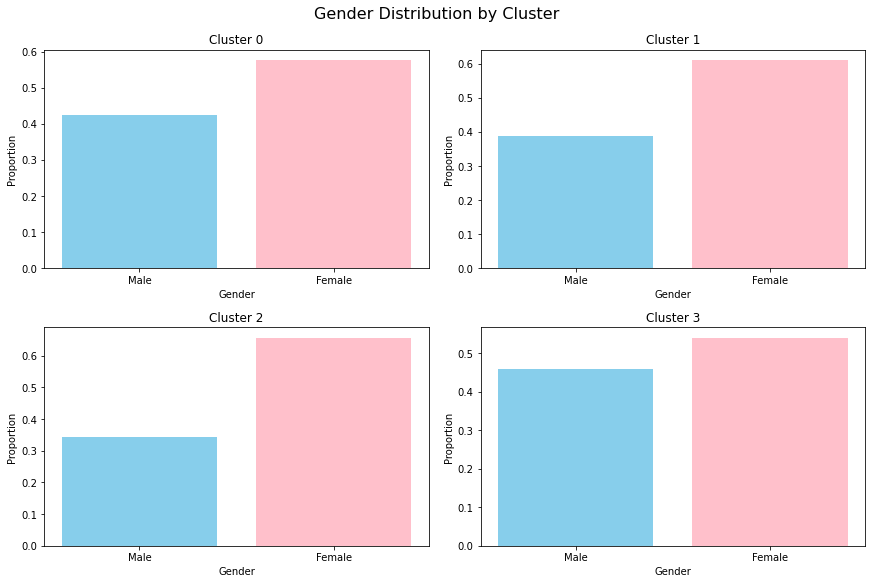

In [10]:
import matplotlib.pyplot as plt

# defining gender categories male and female.
all_gender_categories = [1, 2]
gender_labels = ["Male", "Female"]

# defining number of clusters
num_clusters = demographic_cluster_analysis["Cluster"].nunique()

# for tight layout
fig, axes = plt.subplots(
    nrows=(num_clusters // 2 + num_clusters % 2),
    ncols=2,
    figsize=(12, num_clusters * 2),
    constrained_layout=True
)
axes = axes.flatten()

# plotting gender distribution for each cluster using bargraph
for i, cluster in enumerate(demographic_cluster_analysis["Cluster"]):
    gender_dist = demographic_cluster_analysis.loc[
        demographic_cluster_analysis["Cluster"] == cluster, "gender_distribution"
    ].values[0]
    
    # Filling missing categories with zero.
    gender_dist_full = {gender: gender_dist.get(gender, 0) for gender in all_gender_categories}
    
    ax = axes[i]
    ax.bar(gender_labels, gender_dist_full.values(), color=["skyblue", "pink"])
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Gender")
    ax.set_ylabel("Proportion")

# hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Gender Distribution by Cluster", fontsize=16)
plt.show()


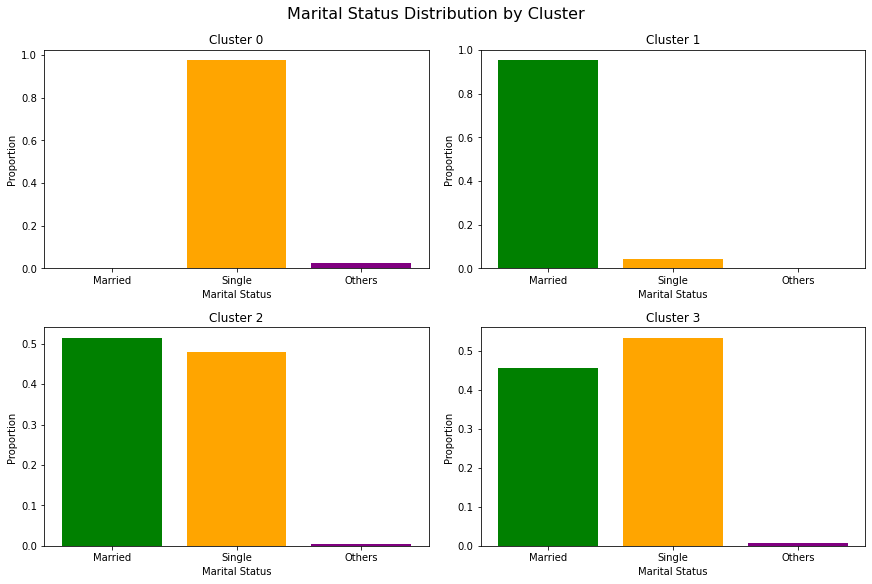

In [11]:
# defining all marital status categories and their labels
all_marital_statuses = [1, 2, 3]
marital_status_labels = ["Married", "Single", "Others"]

# for tight layout
fig, axes = plt.subplots(
    nrows=(num_clusters // 2 + num_clusters % 2),
    ncols=2,
    figsize=(12, num_clusters * 2),
    constrained_layout=True
)
axes = axes.flatten()

# plotting marital status distribution for each cluster using bargraph
for i, cluster in enumerate(demographic_cluster_analysis["Cluster"]):
    marital_dist = demographic_cluster_analysis.loc[
        demographic_cluster_analysis["Cluster"] == cluster, "marital_status_distribution"
    ].values[0]
    
    # Fill missing categories with zero
    marital_dist_full = {status: marital_dist.get(status, 0) for status in all_marital_statuses}
    
    ax = axes[i]
    ax.bar(marital_status_labels, marital_dist_full.values(), color=["green", "orange", "purple"])
    ax.set_title(f"Cluster {cluster}")
    ax.set_xlabel("Marital Status")
    ax.set_ylabel("Proportion")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Marital Status Distribution by Cluster", fontsize=16)
plt.show()


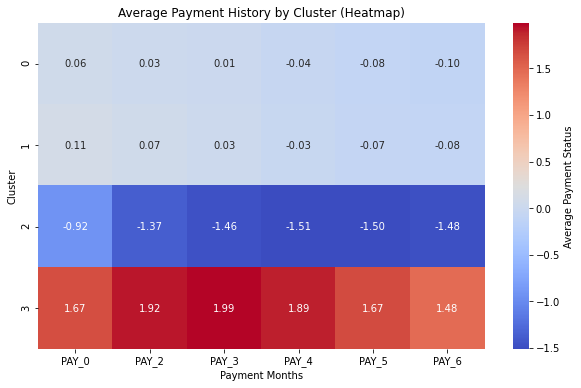

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

#   avg payment history grouped by cluster
payment_history_cluster_analysis = df.groupby("Cluster")[["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]].mean()

#  plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(payment_history_cluster_analysis, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Average Payment Status"})
plt.title("Average Payment History by Cluster (Heatmap)")
plt.xlabel("Payment Months")
plt.ylabel("Cluster")
plt.show()


Final Conclusion: For Clustering Analysis is below,

There are some key findings:

Default Rates by Cluster:

Clusters with poor repayment history have high chances of default.( "PAY_0" - "PAY_6")
Young customers and single customers lead high risk clusters.
Old customers, married customers who have consistent repayment histories have lowest defaults.

Demographic Insights:

Gender Distribution: There are some clusters that shows that males have high proportion of default behaviour.

Marital Status Distribution: Cluster dominated by married customers tend to have low defualt rates and cluster dominated by single have high default rates.

Age Distribution: Hence the young cluster shows high risks, while old clusters are stable financially.

Payment History Insights:
Clusters with repayment delays (positive 'PAY_0' to 'PAY_6' values) correlate strongly with high default rates.
Clusters with timely or full payments (values around 0 or -1) are low risk.

Actionable Insights

High-Risk Clusters:
We can focus on intervention plan for young and single customer with poor payment histories.
We can also suggest to stricter credit assessments and give some personlized remainders.

Low-Risk Clusters:
Leverage older, married customers with good repayment histories for upselling financial products.
Offer loyalty programs or incentives to maintain their low-risk status.


Recommendations

Implement predictive risk models for high-risk clusters.
Design targeted marketing campaigns for low-risk clusters.
Monitor payment behaviors continuously to adjust strategies.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [14]:
df = pd.read_excel('default of credit card clients.xlsx', sheet_name='Data', skiprows=1)
df.columns = [
    "ID", "LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    "DEFAULT"
]

# Drop the 'ID' column as it is not relevant for analysis
df.drop(columns=["ID"], inplace=True)

# Remove rows with missing values in the target variable
data = df.dropna(subset=["DEFAULT"])

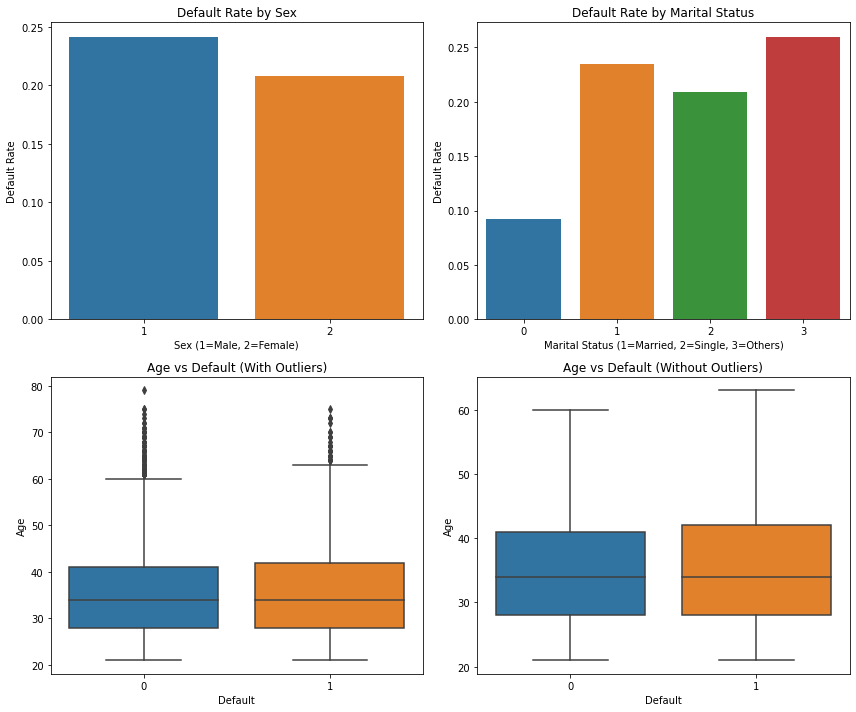

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Default Rate by SEX
sns.barplot(x=data["SEX"], y=data["DEFAULT"], ax=axes[0, 0],ci=None)
axes[0, 0].set_title("Default Rate by Sex")
axes[0, 0].set_xlabel("Sex (1=Male, 2=Female)")
axes[0, 0].set_ylabel("Default Rate")

# Default Rate by MARRIAGE
sns.barplot(x=data["MARRIAGE"], y=data["DEFAULT"], ax=axes[0, 1],ci=None)
axes[0, 1].set_title("Default Rate by Marital Status")
axes[0, 1].set_xlabel("Marital Status (1=Married, 2=Single, 3=Others)")
axes[0, 1].set_ylabel("Default Rate")

# Age Distribution by Default With Outliers
sns.boxplot(x="DEFAULT", y="AGE", data=data, ax=axes[1, 0])
axes[1, 0].set_title("Age vs Default (With Outliers)")
axes[1, 0].set_xlabel("Default")
axes[1, 0].set_ylabel("Age")

# Age Distribution by Default Without Outliers
sns.boxplot(x="DEFAULT", y="AGE", data=data, ax=axes[1, 1], showfliers=False)
axes[1, 1].set_title("Age vs Default (Without Outliers)")
axes[1, 1].set_xlabel("Default")
axes[1, 1].set_ylabel("Age")

# Adjust the layout for better spacing
plt.tight_layout()
plt.show()


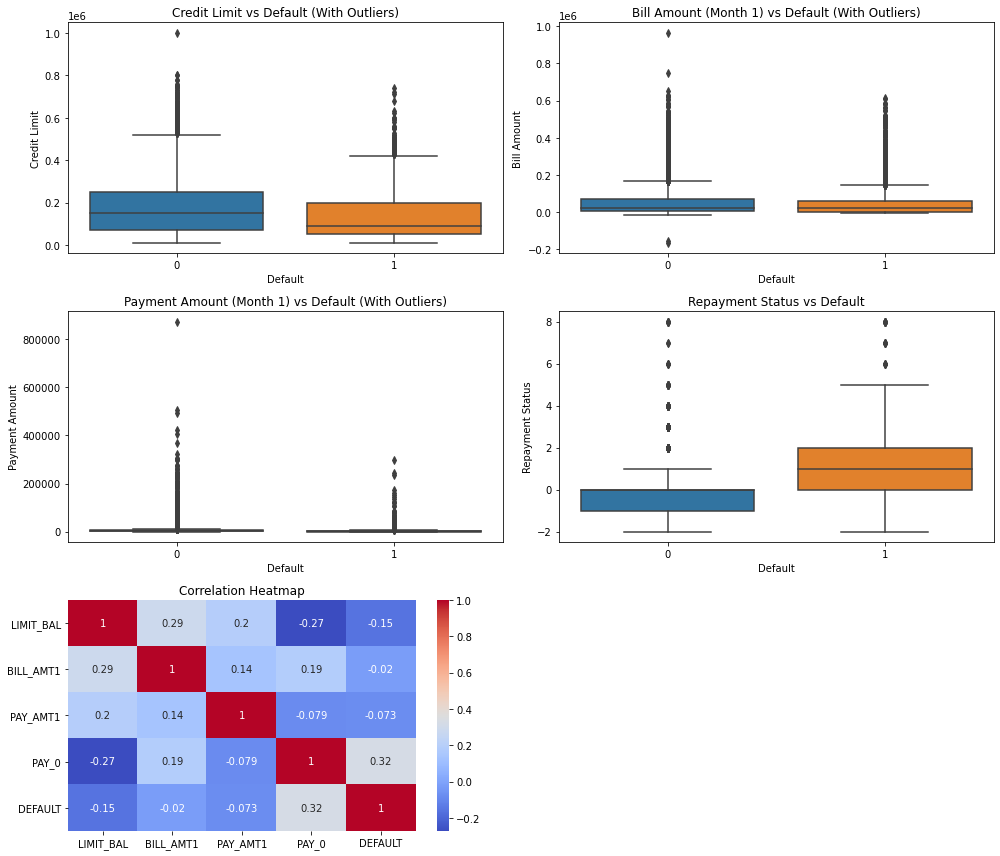

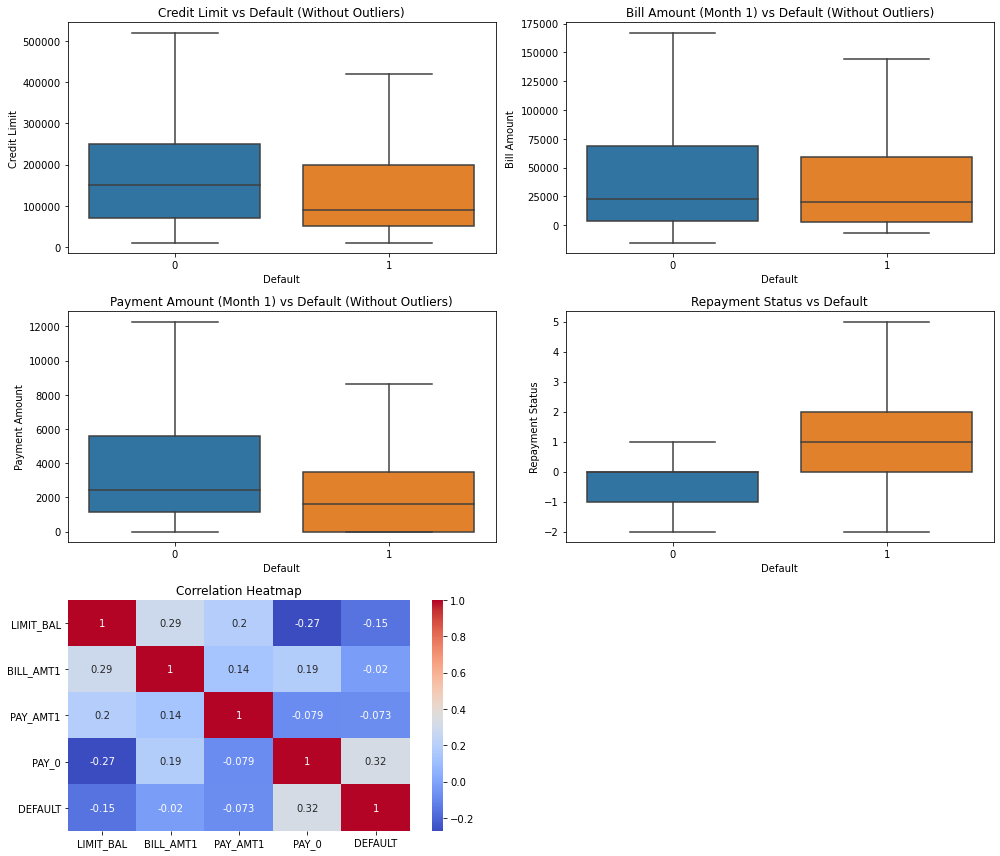

In [16]:
# Financial Analysis 
fig , axes = plt.subplots(3 , 2, figsize=(14, 12))


sns.boxplot(x="DEFAULT", y="LIMIT_BAL", data=data, ax=axes[0, 0])
axes[0, 0].set_title("Credit Limit vs Default (With Outliers)")
axes[0, 0].set_xlabel("Default")
axes[0, 0].set_ylabel("Credit Limit")

sns.boxplot(x="DEFAULT", y="BILL_AMT1", data=data, ax=axes[0, 1])
axes[0, 1].set_title("Bill Amount (Month 1) vs Default (With Outliers)")
axes[0, 1].set_xlabel("Default")
axes[0, 1].set_ylabel("Bill Amount")

sns.boxplot(x="DEFAULT", y="PAY_AMT1", data=data, ax=axes[1, 0])
axes[1, 0].set_title("Payment Amount (Month 1) vs Default (With Outliers)")
axes[1, 0].set_xlabel("Default")
axes[1, 0].set_ylabel("Payment Amount")


sns.boxplot(x="DEFAULT", y="PAY_0", data=data, ax=axes[1, 1])
axes[1, 1].set_title("Repayment Status vs Default")
axes[1, 1].set_xlabel("Default")
axes[1, 1].set_ylabel("Repayment Status")


corr_matrix = data[["LIMIT_BAL", "BILL_AMT1", "PAY_AMT1", "PAY_0", "DEFAULT"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[2, 0])
axes[2, 0].set_title("Correlation Heatmap")

axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Financial Analysis Without Outliers
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
sns.boxplot(x="DEFAULT", y="LIMIT_BAL", data=data, ax=axes[0, 0],showfliers=False)
axes[0, 0].set_title("Credit Limit vs Default (Without Outliers)")
axes[0, 0].set_xlabel("Default")
axes[0, 0].set_ylabel("Credit Limit")

sns.boxplot(x="DEFAULT", y="BILL_AMT1", data=data, ax=axes[0, 1],showfliers=False)
axes[0, 1].set_title("Bill Amount (Month 1) vs Default (Without Outliers)")
axes[0, 1].set_xlabel("Default")
axes[0, 1].set_ylabel("Bill Amount")
sns.boxplot(x="DEFAULT", y="PAY_AMT1", data=data, ax=axes[1,0], showfliers=False)
axes[1 , 0].set_title("Payment Amount (Month 1) vs Default (Without Outliers)")
axes[1 , 0].set_xlabel("Default")

axes[1 , 0].set_ylabel("Payment Amount")
sns.boxplot(x="DEFAULT", y="PAY_0", data=data, ax=axes[1, 1],showfliers=False)
axes[1, 1].set_title("Repayment Status vs Default")
axes[1, 1].set_xlabel("Default")
axes[1, 1].set_ylabel("Repayment Status")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", ax=axes[2,0])
axes[2, 0].set_title("Correlation Heatmap")
axes[2, 1].axis('off')

# USing tight layout to show all the graphs in single frame.
plt.tight_layout()
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = data.drop(columns=["DEFAULT"])
y = data["DEFAULT"]

# Scale numerical variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


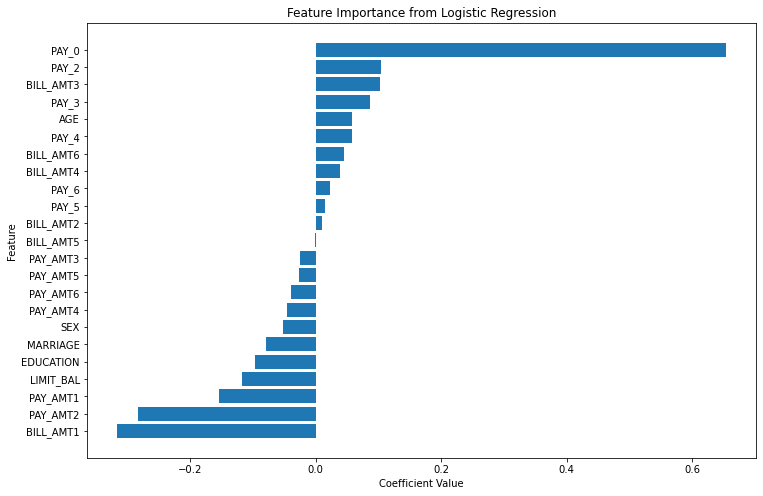

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_lr = log_reg.predict(X_test)
y_pred_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# Get classification report as a dictionary
log_reg_report = classification_report(y_test, y_pred_lr, output_dict=True)  # Change here
log_reg_roc_auc = roc_auc_score(y_test, y_pred_prob_lr)

# Feature Importance
coefficients = log_reg.coef_[0]
feature_importance = pd.DataFrame({
    "Feature": data.columns[:-1],
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance["Feature"], feature_importance["Coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance from Logistic Regression")
plt.gca().invert_yaxis()
plt.show()


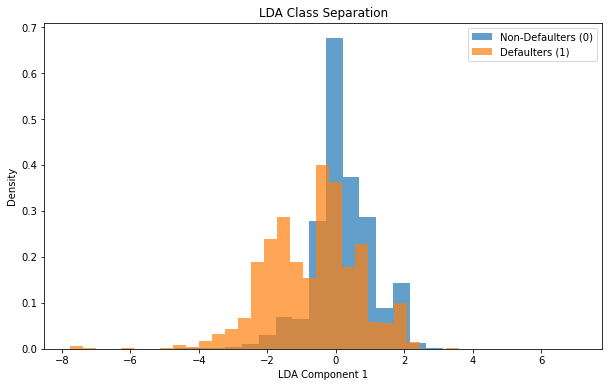

LDA Feature Contributions:
----------------------------------------
      Feature  LDA Coefficient
5       PAY_0         0.711817
6       PAY_2         0.162049
7       PAY_3         0.094999
4         AGE         0.075386
16  BILL_AMT6         0.063190
8       PAY_4         0.055259
10      PAY_6         0.022176
9       PAY_5         0.015084
14  BILL_AMT4         0.011012
19   PAY_AMT3         0.008606
13  BILL_AMT3         0.000321
22   PAY_AMT6        -0.011561
12  BILL_AMT2        -0.012232
20   PAY_AMT4        -0.016161
21   PAY_AMT5        -0.024051
15  BILL_AMT5        -0.031233
1         SEX        -0.048194
17   PAY_AMT1        -0.053090
18   PAY_AMT2        -0.063525
3    MARRIAGE        -0.079680
0   LIMIT_BAL        -0.092201
2   EDUCATION        -0.092425
11  BILL_AMT1        -0.256905


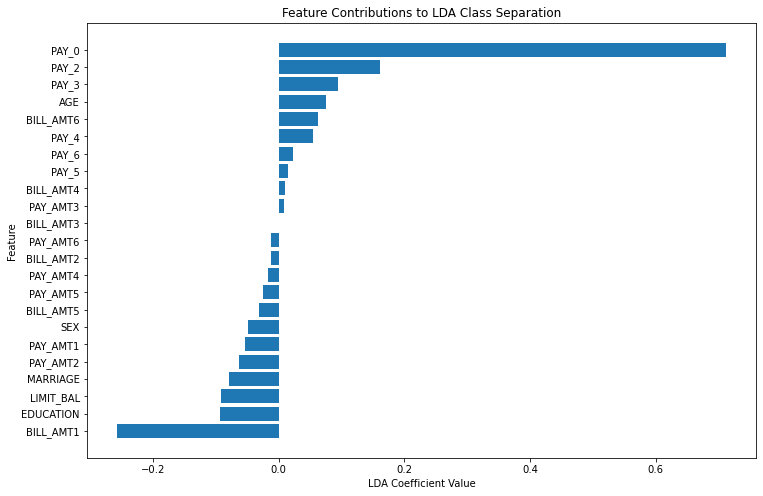

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Linear Discriminant Analysis model
lda = LDA()
lda.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_lda = lda.predict(X_test)
y_pred_prob_lda = lda.predict_proba(X_test)[:, 1]
lda_report = classification_report(y_test, y_pred_lda, output_dict=True)  # Add output_dict=True
lda_roc_auc = roc_auc_score(y_test, y_pred_prob_lda)

# Visualize LDA Class Separation
X_test_lda = lda.transform(X_test)
plt.figure(figsize=(10, 6))
plt.hist(X_test_lda[y_test == 0], bins=30, alpha=0.7, label="Non-Defaulters (0)", density=True)
plt.hist(X_test_lda[y_test == 1], bins=30, alpha=0.7, label="Defaulters (1)", density=True)
plt.title("LDA Class Separation")
plt.xlabel("LDA Component 1")
plt.ylabel("Density")
plt.legend()
plt.show()

# Extract LDA coefficients
lda_coefficients = pd.DataFrame({
    "Feature": data.columns[:-1],
    "LDA Coefficient": lda.coef_[0]
}).sort_values(by="LDA Coefficient", ascending=False)

# Print LDA coefficients sorted by importance
print("LDA Feature Contributions:")
print("-" * 40)
print(lda_coefficients)

# Visualize LDA feature contributions
plt.figure(figsize=(12, 8))
plt.barh(lda_coefficients["Feature"], lda_coefficients["LDA Coefficient"])
plt.xlabel("LDA Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Contributions to LDA Class Separation")
plt.gca().invert_yaxis()
plt.show()



Logistic Regression Results:
----------------------------------------
Accuracy: 80.82%
ROC-AUC Score: 0.72

Key Insights from Logistic Regression:
1. Features with the highest positive coefficients (more likely to default):
      Feature  Coefficient
5       PAY_0     0.653902
6       PAY_2     0.103733
13  BILL_AMT3     0.102266
7       PAY_3     0.086041
4         AGE     0.058517 

2. Features with the highest negative coefficients (less likely to default):
      Feature  Coefficient
2   EDUCATION    -0.095877
0   LIMIT_BAL    -0.116683
17   PAY_AMT1    -0.154058
18   PAY_AMT2    -0.283327
11  BILL_AMT1    -0.316106 

LDA Results:
----------------------------------------
Accuracy: 80.90%
ROC-AUC Score: 0.71

Key Insights from LDA:
1. Features contributing most to class separation:
      Feature  LDA Coefficient
5       PAY_0         0.711817
6       PAY_2         0.162049
7       PAY_3         0.094999
4         AGE         0.075386
16  BILL_AMT6         0.063190


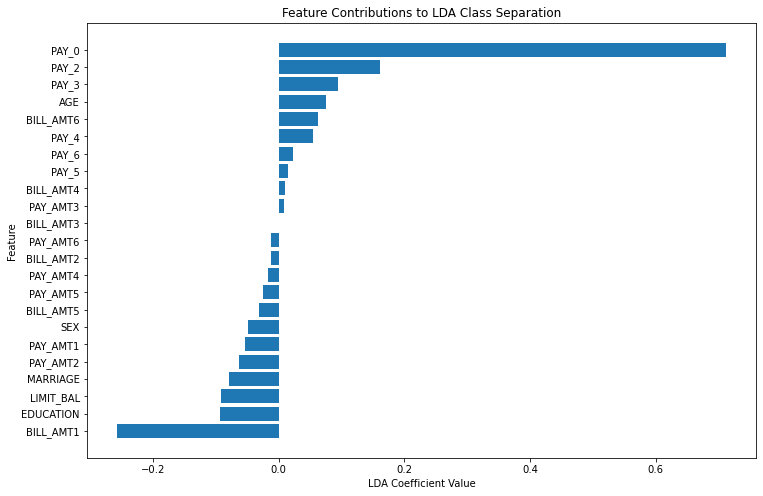

Model Comparison:
----------------------------------------
Logistic Regression performs better in terms of ROC-AUC.

Recommendation:
- Choose Logistic Regression for feature interpretability.
- Use LDA for visualizing separability and understanding group distinctions.


In [20]:
# Logistic Regression: Drawing Conclusions
print("Logistic Regression Results:")
print("-" * 40)
print(f"Accuracy: {log_reg_report['accuracy'] * 100:.2f}%")
print(f"ROC-AUC Score: {log_reg_roc_auc:.2f}\n")

print("Key Insights from Logistic Regression:")
print("1. Features with the highest positive coefficients (more likely to default):")
print(feature_importance[feature_importance["Coefficient"] > 0].head(5), "\n")

print("2. Features with the highest negative coefficients (less likely to default):")
print(feature_importance[feature_importance["Coefficient"] < 0].tail(5), "\n")

# LDA Conclusions
try:
    lda_coefficients = pd.DataFrame({
        "Feature": data.columns[:-1],
        "LDA Coefficient": lda.coef_[0]
    }).sort_values(by="LDA Coefficient", ascending=False)

    print("LDA Results:")
    print("-" * 40)
    print(f"Accuracy: {lda_report['accuracy'] * 100:.2f}%")
    print(f"ROC-AUC Score: {lda_roc_auc:.2f}\n")

    print("Key Insights from LDA:")
    print("1. Features contributing most to class separation:")
    print(lda_coefficients.head(5))

    # Visualizing LDA feature contributions
    plt.figure(figsize=(12, 8))
    plt.barh(lda_coefficients["Feature"], lda_coefficients["LDA Coefficient"])
    plt.xlabel("LDA Coefficient Value")
    plt.ylabel("Feature")
    plt.title("Feature Contributions to LDA Class Separation")
    plt.gca().invert_yaxis()
    plt.show()

except AttributeError:
    print("LDA does not provide direct coefficients for class separation. Only visual separability is available.\n")

# here we will compare the Models
print("Model Comparison:")
print("-" * 40)
if log_reg_roc_auc > lda_roc_auc:
    print("Logistic Regression performs better in terms of ROC-AUC.")
else:
    print("LDA performs better in terms of ROC-AUC.")
print("\nRecommendation:")
print("- Choose Logistic Regression for feature interpretability.")
print("- Use LDA for visualizing separability and understanding group distinctions.")


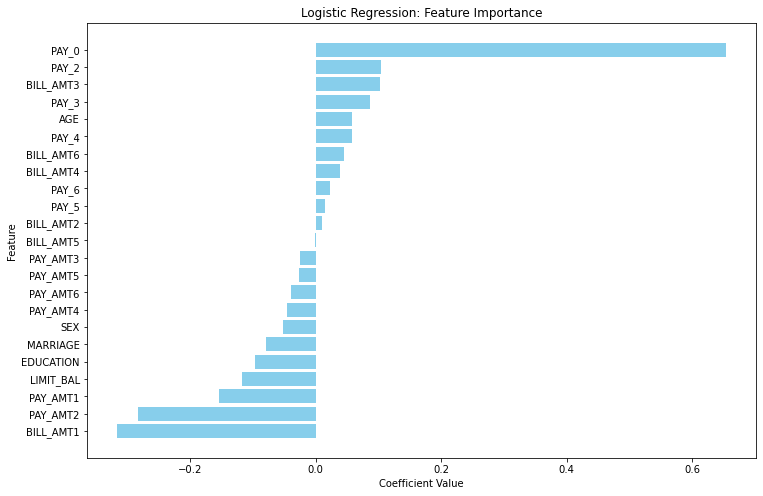

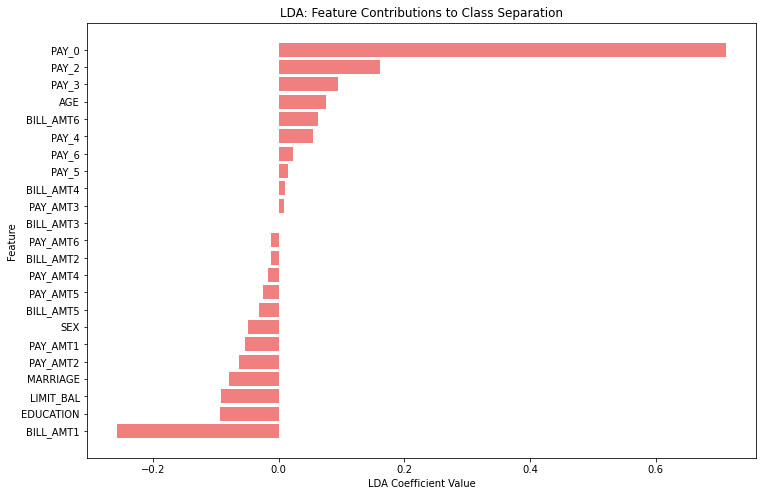

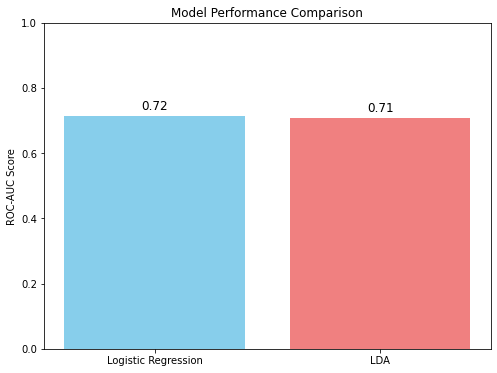

In [21]:
import matplotlib.pyplot as plt

# Visualizing Logistic Regression 
plt.figure(figsize=(12, 8))
plt.barh(feature_importance["Feature"], feature_importance["Coefficient"], color='skyblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Logistic Regression: Feature Importance")
plt.gca().invert_yaxis()
plt.show()

# Visualizing LDA 
try:
    plt.figure(figsize=(12, 8))
    plt.barh(lda_coefficients["Feature"], lda_coefficients["LDA Coefficient"], color='lightcoral')
    plt.xlabel("LDA Coefficient Value")
    plt.ylabel("Feature")
    plt.title("LDA: Feature Contributions to Class Separation")
    plt.gca().invert_yaxis()
    plt.show()
except NameError:
    print("LDA coefficients are not available for visualization.")

# here we will compare model performance
models = ['Logistic Regression', 'LDA']
roc_auc_scores = [log_reg_roc_auc, lda_roc_auc]

plt.figure(figsize=(8, 6))
plt.bar(models, roc_auc_scores, color=['skyblue', 'lightcoral'])
plt.ylabel("ROC-AUC Score")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)  # ROC-AUC scores are always between 0 and 1
for i, score in enumerate(roc_auc_scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=12)
plt.show()


Insights from Logistic Regression:

Key Predictors:

Positive Predictors: PAY_0 is the most powerful predictor, representing the status of the most
 recent repayment. Customers who have paid belatedly are much more likely to default. PAY_2
 and PAY_3, along with other statuses related to repayments, also positively determine the
 likelihood of default.
 
 
 Negative Predictors: PAY_AMT1 is the strongest feature which reduces the likelihood of default,
 referring to the payment amount in the most recent month. Higher payments indicate reduced
 risk.LIMIT_BAL, related to the credit limit, is negatively correlated with default; higher credit
 limits infer a lower probability of customers who will default. BILL_AMT1, refers to the amount of
 the bill, inversely influencing the default, which reflects responsibility with credit.

Model Performance:
Logistic Regression achieved a ROC-AUC score of 0.715, indicate a ability to rank defaulters correctly.
It provides interpretable coefficients, which help identify and quantify the contribution of each feature to predicting default.
Logistic Regression achieved an accuracy of 80.82%.

Insights from LDA:

Class Separation:
LDA effectively separates defaulters and non-defaulters by showing data on discriminant axis.
The class separation histogram shows overlap between the two classes, indicates challenges in perfect discrimination but still gives distinct groups.

Feature Contributions:
While LDA doesn’t directly identify feature importance in influencing default , its coefficients suggest that repayment status (PAY_0, PAY_2) and financial metrics (LIMIT_BAL) contribute highly to class separation.

Model Performance:
LDA achieved a ROC-AUC score of 0.709, comparable to Logistic Regression.
The model is good in visualizing class separability but lacks the interpretability of feature-level importance.


Conclusion:

Logistic Regression gives a clear understanding of what drives the default, making it easy for risk management strategies, such as prioritizing high-risk customers.
LDA complements Logistic Regression by confirming the dataset's ability to classify defaulters and non-defaulters.
Together, these models offer a comprehensive approach for predicting and managing customer defaults. 


In [ ]:
THE END.